In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 24 10:43:31 2019

@author: raiak
"""

import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta, TH
import matplotlib.pyplot as plt



In [2]:
def optionChain (expirydate):

    urlheader = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36",
      "authority": "www.nseindia.com",
      "scheme":"https"
    }
    
    url="https://www.nseindia.com/live_market/dynaContent/live_watch/option_chain/optionKeys.jsp?"
    params="segmentLink=17&instrument=OPTIDX&symbol=NIFTY&date="
    #expirydate="3OCT2019"
    
    url_encoded=url + params + expirydate
    
    req = requests.get(url_encoded, headers=urlheader)
    soup = BeautifulSoup(req.content, "lxml")
    table = soup.find('table', id="octable")
    
    rows = table.findAll('tr')
    header_text = []
    headers = rows[1]
    
    remove_indices_for_put = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,18,22]
    remove_indices_for_call = [0,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22]
     # Creating an empty Dataframe with column names only
    
    
    # add the header text to array
    for th in headers.findAll('th'):
        header_text.append(th.text)
    
    header_text = [i for j, i in enumerate(header_text) if j not in remove_indices_for_put]
    df_call = pd.DataFrame(columns=header_text)
    df_put = pd.DataFrame(columns=header_text)
    
    #row_text_array = []
    for row in rows[2:-1]:
        row_text = []
        row_text_call = []
        row_text_put = []
        # loop through the elements
        for row_element in row.findAll(['th', 'td']):
            # append the array with the elements inner text
            row_text.append(row_element.text.replace('\n', '').strip())
    
        # append the text array to the row text array
        row_text_put = [i for j, i in enumerate(row_text) if j not in remove_indices_for_put]
        for i in range(len(row_text_put)):
            if (row_text_put[i]=='-'):
                row_text_put[i]=0
            else:
                row_text_put[i]=row_text_put[i].replace(',', '')
                row_text_put[i]=float(row_text_put[i])
        row_text_call = [i for j, i in enumerate(row_text) if j not in remove_indices_for_call]
        row_call_temp=[None] * len(row_text_call)
        for i in range(len(row_text_call)):       
            if (row_text_call[i]=='-'):
                row_call_temp[len(row_text_call)-i-1]=0
            else:
                row_text_call[i]=row_text_call[i].replace(',', '')
                row_text_call[i]=float(row_text_call[i])
                row_call_temp[len(row_text_call)-i-1]=row_text_call[i]
        df_call = df_call.append(pd.Series(dict(zip(df_call.columns, row_call_temp))), ignore_index=True)
        df_put = df_put.append(pd.Series(dict(zip(df_put.columns, row_text_put))), ignore_index=True)    
        
        
    df_call['OI'] = pd.to_numeric(df_call['OI'])
    df_call=df_call.nlargest(3, ['OI'])
    df_call.set_index('Strike Price', inplace=True)
    print("Top 3 Strike price of Call Option based on Open Interest for Expiry Date = "+expirydate)
    df_call=df_call.sort_index(axis = 0) 
    print(df_call)
    
   
    df_call.plot.barh(title='Top 3 Call Option based on OI for Option Expiry = '+expirydate)
    
 
    
    print("================================================================================") 
    df_put['OI'] = pd.to_numeric(df_put['OI'])
    df_put=df_put.nlargest(3, ['OI'])
    df_put.set_index('Strike Price', inplace=True)
    print("Top 3 Strike price of Put Option based on Open Interest for Expiry Date = "+expirydate)
    print(df_put)
    df_put=df_put.sort_index(axis = 0) 
    df_put.plot.barh( title='Top 3 Put Option based on OI for Option Expiry = '+expirydate)
    return(df_call,df_put)



In [3]:
def nextThu_and_lastThu_expiry_date ():

    todayte = datetime.today()
    
    cmon = todayte.month
    if_month_next=(todayte + relativedelta(weekday=TH(1))).month
    next_thursday_expiry=todayte + relativedelta(weekday=TH(1))
   
    if (if_month_next!=cmon):
        month_last_thu_expiry= todayte + relativedelta(weekday=TH(5))
        if (month_last_thu_expiry.month!=if_month_next):
            month_last_thu_expiry= todayte + relativedelta(weekday=TH(4))
    else:
        for i in range(1, 7):
            t = todayte + relativedelta(weekday=TH(i))
            if t.month != cmon:
                # since t is exceeded we need last one  which we can get by subtracting -2 since it is already a Thursday.
                t = t + relativedelta(weekday=TH(-2))
                month_last_thu_expiry=t
                break
    str_month_last_thu_expiry=str(int(month_last_thu_expiry.strftime("%d")))+month_last_thu_expiry.strftime("%b").upper()+month_last_thu_expiry.strftime("%Y")
    str_next_thursday_expiry=str(int(next_thursday_expiry.strftime("%d")))+next_thursday_expiry.strftime("%b").upper()+next_thursday_expiry.strftime("%Y")
    return (str_next_thursday_expiry,str_month_last_thu_expiry)


In [6]:
str_next_thursday_expiry,str_month_last_thu_expiry=nextThu_and_lastThu_expiry_date()
print("================================================================================")
print("Next Expiry Date = " + str_next_thursday_expiry)
print("================================================================================")
print("Month End Expiry Date = " + str_month_last_thu_expiry)
print("================================================================================")

Next Expiry Date = 3OCT2019
Month End Expiry Date = 31OCT2019


Call/Put Option data of next Thursday expiry =  3OCT2019
Top 3 Strike price of Call Option based on Open Interest for Expiry Date = 3OCT2019
                LTP    Volume  Chng in OI         OI
Strike Price                                        
11500.0       60.00  423953.0    696825.0  1609575.0
11600.0       25.60  318676.0    198225.0  2265975.0
11700.0        9.75  228059.0    109725.0  1685325.0
Top 3 Strike price of Put Option based on Open Interest for Expiry Date = 3OCT2019
                LTP    Volume  Chng in OI         OI
Strike Price                                        
11400.0       23.90  376299.0    827400.0  1983900.0
11200.0        4.50  130578.0    245250.0  1164075.0
11500.0       60.55  238375.0   -122475.0  1108725.0


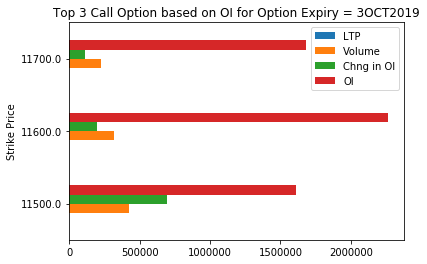

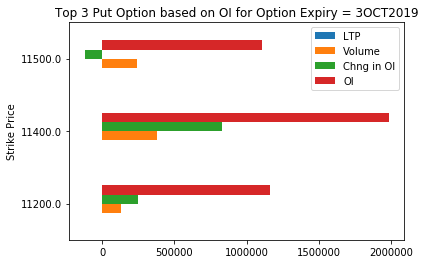

In [8]:
print("Call/Put Option data of next Thursday expiry =  "+str_next_thursday_expiry)
print("================================================================================")
df_call_near_expiry,df_put_near_expiry=optionChain(str_next_thursday_expiry)

Call/Put Option data of last Thursday of a month expiry =  31OCT2019
Top 3 Strike price of Call Option based on Open Interest for Expiry Date = 31OCT2019
                LTP   Volume  Chng in OI         OI
Strike Price                                       
11200.0       425.0   2186.0      7800.0  1732350.0
11500.0       224.0  40028.0    247650.0  1974000.0
12000.0        43.6  41541.0    242400.0  1961100.0
Top 3 Strike price of Put Option based on Open Interest for Expiry Date = 31OCT2019
                LTP   Volume  Chng in OI         OI
Strike Price                                       
11000.0        48.2  25830.0     18300.0  1841850.0
11500.0       180.0  36932.0     23925.0  1336500.0
10000.0         3.6   9618.0    396825.0  1282650.0


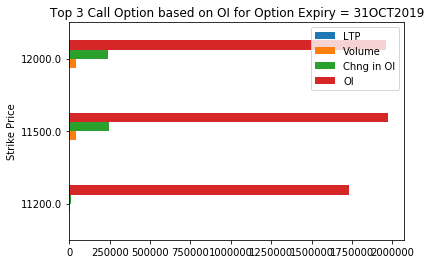

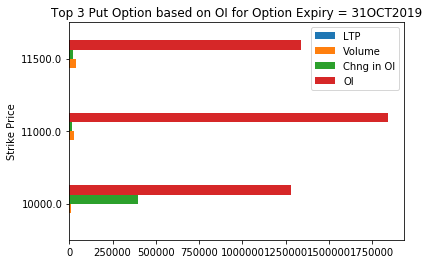

In [9]:
print("================================================================================")
print("Call/Put Option data of last Thursday of a month expiry =  "+str_month_last_thu_expiry)
df_put_near_expiry,df_put_last_expiry=optionChain(str_month_last_thu_expiry)
print("================================================================================")